In [1]:
# ----- Setup -----
import os
from pathlib import Path
import xarray as xr
import dask
from dask.diagnostics import ProgressBar


In [3]:
# Your root folder (Windows)
ROOT = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016")

# Sanity checks
print("Root exists? ->", ROOT.exists())
if not ROOT.exists():
    raise FileNotFoundError(f"Check the path: {ROOT}")

Root exists? -> True


In [4]:
# output folder
Figures = Path(r"D:\Users\abolmaal\modelling\Figures")

In [4]:
ds = xr.open_mfdataset(os.path.join(ROOT, "*.nc"), combine="by_coords")
ds

<xarray.Dataset> Size: 190MB
Dimensions:          (time: 12, bnds: 2, lat: 224, lon: 464)
Coordinates:
  * lon              (lon) float32 2kB -124.9 -124.8 -124.7 ... -67.19 -67.06
  * lat              (lat) float32 896B 25.06 25.19 25.31 ... 52.69 52.81 52.94
  * time             (time) datetime64[ns] 96B 2016-01-01 ... 2016-12-01
Dimensions without coordinates: bnds
Data variables: (12/39)
    time_bnds        (time, bnds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    SWdown           (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    LWdown           (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    SWnet            (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    LWnet            (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Qle              (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    ...               ...
    CanopInt         (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    ACond            (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    CCond            (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    LAI              (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    GVEG             (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Streamflow       (time, lat, lon) float32 5MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        monthly
    shortname:              NLDAS_MOS0125_M_2.0
    title:                  NLDAS Mosaic Land Surface Model L4 Monthly 0.125 ...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

In [ ]:
# plot the average of Qs over time
qs_mean = ds['Qs'].mean(dim='time')
qs_mean.plot()



# Plot the Runoff data for year 2016 over Michigan

In [ ]:
countries = gpd.read_file(r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_cultural/ne_10m_admin_0_countries_lakes.shp")
MI_LINES  = Path(r"S:/Data/GIS_Data/Derived/MI_Model/Watersheds/MI_Model_HUC6.shp")

[INFO] 'Qsb' found in group: /


NameError: name 'Figures' is not defined

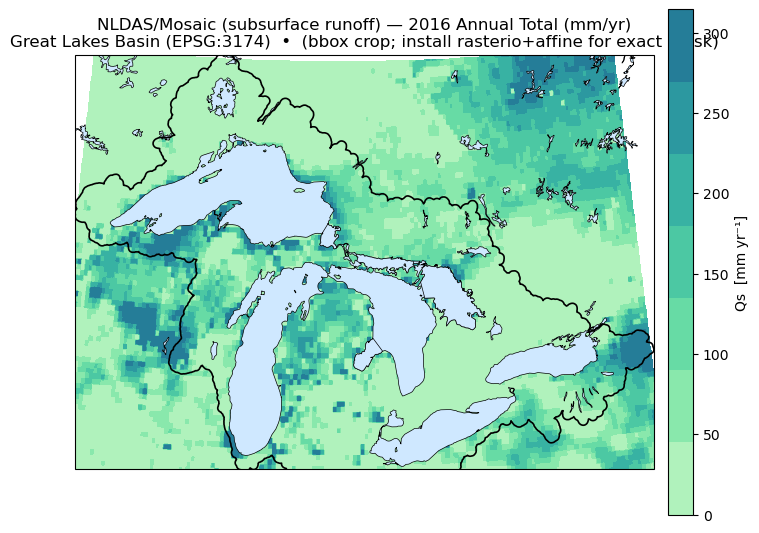

In [1]:
# ==== NLDAS/Mosaic Qs — 2016 Annual Total (mm/yr),
#      clipped to GL boundary, smooth plot in EPSG:3174
#      with lakes overlay ====
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps 
# -------------------- Paths & constants --------------------
ROOT_2016   = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016")
VAR         = "Qsb"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT  = 4326
CRS_PLOT    = 3174  # Great Lakes Albers

# -------------------- Find which group contains the variable --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root
        return walk(nc, "")

# -------------------- Collect & open all 2016 files --------------------
files = sorted(str(p) for p in ROOT_2016.rglob("*.nc*"))
if not files:
    raise FileNotFoundError(f"No .nc/.nc4 files found under {ROOT_2016}")

group_path = find_group_with_var(files[0], VAR)
if group_path is None:
    raise KeyError(f"Variable '{VAR}' not found in {files[0]} (root or any subgroup).")
print(f"[INFO] '{VAR}' found in group: {group_path or '/'}")

open_kwargs = dict(
    combine="by_coords",
    chunks={"time": 12},
    parallel=False,
    decode_times=True,
    engine="netcdf4",
    backend_kwargs={"autoclose": True},
)
ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)
if VAR not in ds:
    raise KeyError(f"{VAR!r} not in dataset. Available: {list(ds.data_vars)[:20]}")

# -------------------- Annual total (mm/yr) --------------------
# Monthly totals: kg/m^2 == mm/month → sum across months
da = ds[VAR].sum("time", skipna=True)
da.attrs["units"] = "mm yr-1"
da.attrs["long_name"] = "Subsurface runoff (Qs) annual total"

# -------------------- Tidy coords (lon/lat ascending; lon in [-180,180]) --------------------
lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
if not (lon_name and lat_name):
    raise KeyError("Couldn't find lon/lat coords.")

lon_fix = xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])
da = da.assign_coords({lon_name: lon_fix})
if not np.all(np.diff(da[lon_name].values) > 0):
    da = da.sortby(lon_name)
if not np.all(np.diff(da[lat_name].values) > 0):
    da = da.sortby(lat_name)

lon_vals = da[lon_name].values
lat_vals = da[lat_name].values

# -------------------- Clip to GL boundary (mask on lon/lat grid) --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

masked = da
used_bbox_only = False
try:
    from rasterio.features import rasterize
    from affine import Affine
    dlon = float(lon_vals[1] - lon_vals[0])
    dlat = float(lat_vals[1] - lat_vals[0])
    transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                       float(lat_vals.min()) - dlat/2)
                    * Affine.scale(dlon, dlat))
    shapes = [(glb_poly.__geo_interface__, 1)]
    mask = rasterize(shapes, out_shape=(lat_vals.size, lon_vals.size),
                     transform=transform_ll, fill=0).astype(bool)
    masked = da.where(xr.DataArray(mask, dims=(lat_name, lon_name)), np.nan)
except Exception:
    used_bbox_only = True
    xmin, ymin, xmax, ymax = glb_ll.total_bounds
    masked = da.sel({lon_name: slice(xmin, xmax), lat_name: slice(ymin, ymax)})

# -------------------- Prep arrays for smooth plotting --------------------
da_plot = masked.transpose(lat_name, lon_name)  # (lat, lon)
Z = np.asarray(da_plot)

lat_for_extent = da_plot[lat_name].values
lon_for_extent = da_plot[lon_name].values

# Ensure imshow origin='lower' matches increasing lat/lon
if not np.all(np.diff(lat_for_extent) > 0):
    Z = Z[::-1, :]
    lat_for_extent = np.sort(lat_for_extent)
if not np.all(np.diff(lon_for_extent) > 0):
    Z = Z[:, ::-1]
    lon_for_extent = np.sort(lon_for_extent)

extent_lonlat = [float(lon_for_extent.min()), float(lon_for_extent.max()),
                 float(lat_for_extent.min()), float(lat_for_extent.max())]

# Robust color limits
finite = np.isfinite(Z)
vmin = np.nanpercentile(Z[finite], 2) if np.any(finite) else None
vmax = np.nanpercentile(Z[finite], 98) if np.any(finite) else None
if vmin is not None and vmax is not None and vmin >= vmax:
    vmin = vmax = None

# -------------------- Read + project lakes --------------------
lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

# -------------------- Plot (smooth, EPSG:3174) with GL extent + lakes --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=proj)

# Smooth raster (bilinear resampling lon/lat → EPSG:3174)
im = ax.imshow(
    Z,
    extent=extent_lonlat,
    transform=pc,             # data CRS
    origin="lower",
    interpolation="bilinear", # smoothing
    cmap=cmaps.tealgrn,
    vmin=vmin, vmax=vmax,
    zorder=1,
)

# Lakes (light blue fill, black edge)
lakes_proj.plot(
    ax=ax,
    facecolor="#cfe8ff",      # light blue fill
    edgecolor="black",        # black outline
    linewidth=0.5,
    zorder=2,
)

# GL boundary overlay
glb_proj = glb_ll.to_crs(CRS_PLOT)
glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

# Extent EXACTLY = GL_BOUNDARY extent in EPSG:3174
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps
ax.set_extent([minx, maxx, miny, maxy], crs=proj)

# Colorbar & title
cb = plt.colorbar(im, ax=ax, shrink=0.82, pad=0.02)
cb.set_label("Qs  [mm yr⁻¹]")

title = "NLDAS/Mosaic (subsurface runoff) — 2016 Annual Total (mm/yr)\nGreat Lakes Basin (EPSG:3174)"
if used_bbox_only:
    title += "  •  (bbox crop; install rasterio+affine for exact mask)"
ax.set_title(title)
plt.savefig(Figures / "nldas_mosaic_qs_2016_glb.png", dpi=300)
plt.tight_layout()
plt.show()



[INFO] 'Qsb' found in group: /


NameError: name 'Figures' is not defined

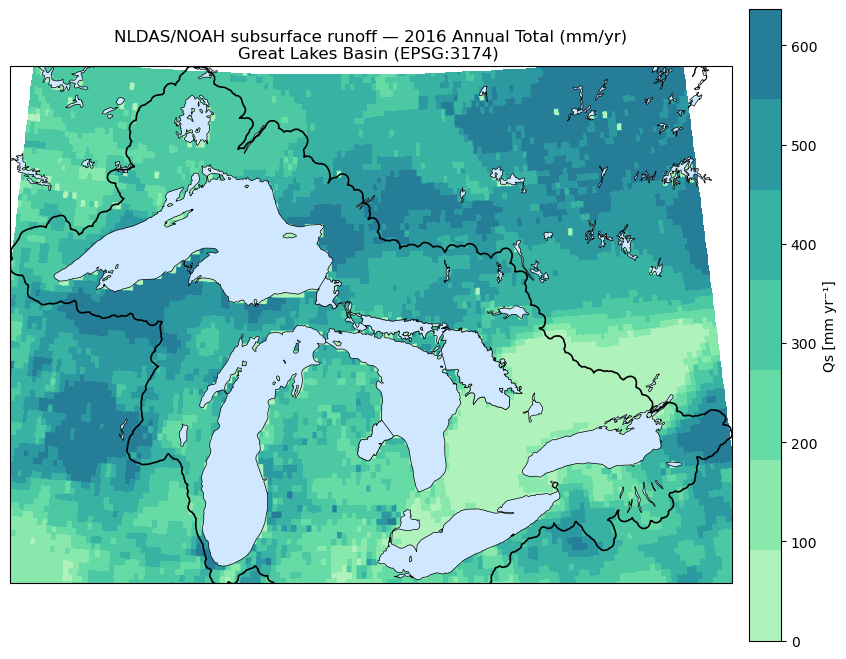

In [2]:
# ==== NLDAS/Mosaic Qs — 2016 Annual Total (mm/yr),
#      clipped to GL boundary, smooth plot in EPSG:3174
#      with lakes overlay ====
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps 
# -------------------- Paths & constants --------------------
ROOT_2016   = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Noah\NLDAS\NLDAS_NOAH0125_M.2.0\2016")
VAR         = "Qsb"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT  = 4326
CRS_PLOT    = 3174  # Great Lakes Albers

# -------------------- Find which group contains the variable --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root
        return walk(nc, "")

# -------------------- Collect & open all 2016 files --------------------
files = sorted(str(p) for p in ROOT_2016.rglob("*.nc*"))
if not files:
    raise FileNotFoundError(f"No .nc/.nc4 files found under {ROOT_2016}")

group_path = find_group_with_var(files[0], VAR)
if group_path is None:
    raise KeyError(f"Variable '{VAR}' not found in {files[0]} (root or any subgroup).")
print(f"[INFO] '{VAR}' found in group: {group_path or '/'}")

open_kwargs = dict(
    combine="by_coords",
    chunks={"time": 12},
    parallel=False,
    decode_times=True,
    engine="netcdf4",
    backend_kwargs={"autoclose": True},
)
ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)
if VAR not in ds:
    raise KeyError(f"{VAR!r} not in dataset. Available: {list(ds.data_vars)[:20]}")

# -------------------- Annual total (mm/yr) --------------------
# Monthly totals: kg/m^2 == mm/month → sum across months
da = ds[VAR].sum("time", skipna=True)
da.attrs["units"] = "mm yr-1"
da.attrs["long_name"] = "Subsurface runoff (Qs) annual total"

# -------------------- Tidy coords (lon/lat ascending; lon in [-180,180]) --------------------
lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
if not (lon_name and lat_name):
    raise KeyError("Couldn't find lon/lat coords.")

lon_fix = xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])
da = da.assign_coords({lon_name: lon_fix})
if not np.all(np.diff(da[lon_name].values) > 0):
    da = da.sortby(lon_name)
if not np.all(np.diff(da[lat_name].values) > 0):
    da = da.sortby(lat_name)

lon_vals = da[lon_name].values
lat_vals = da[lat_name].values

# -------------------- Clip to GL boundary (mask on lon/lat grid) --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

masked = da
used_bbox_only = False
try:
    from rasterio.features import rasterize
    from affine import Affine
    dlon = float(lon_vals[1] - lon_vals[0])
    dlat = float(lat_vals[1] - lat_vals[0])
    transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                       float(lat_vals.min()) - dlat/2)
                    * Affine.scale(dlon, dlat))
    shapes = [(glb_poly.__geo_interface__, 1)]
    mask = rasterize(shapes, out_shape=(lat_vals.size, lon_vals.size),
                     transform=transform_ll, fill=0).astype(bool)
    masked = da.where(xr.DataArray(mask, dims=(lat_name, lon_name)), np.nan)
except Exception:
    used_bbox_only = True
    xmin, ymin, xmax, ymax = glb_ll.total_bounds
    masked = da.sel({lon_name: slice(xmin, xmax), lat_name: slice(ymin, ymax)})

# -------------------- Prep arrays for smooth plotting --------------------
da_plot = masked.transpose(lat_name, lon_name)  # (lat, lon)
Z = np.asarray(da_plot)

lat_for_extent = da_plot[lat_name].values
lon_for_extent = da_plot[lon_name].values

# Ensure imshow origin='lower' matches increasing lat/lon
if not np.all(np.diff(lat_for_extent) > 0):
    Z = Z[::-1, :]
    lat_for_extent = np.sort(lat_for_extent)
if not np.all(np.diff(lon_for_extent) > 0):
    Z = Z[:, ::-1]
    lon_for_extent = np.sort(lon_for_extent)

extent_lonlat = [float(lon_for_extent.min()), float(lon_for_extent.max()),
                 float(lat_for_extent.min()), float(lat_for_extent.max())]

# Robust color limits
finite = np.isfinite(Z)
vmin = np.nanpercentile(Z[finite], 2) if np.any(finite) else None
vmax = np.nanpercentile(Z[finite], 98) if np.any(finite) else None
if vmin is not None and vmax is not None and vmin >= vmax:
    vmin = vmax = None

# -------------------- Read + project lakes --------------------
lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

# -------------------- Plot (smooth, EPSG:3174) with GL extent + lakes --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=proj)

# Smooth raster (bilinear resampling lon/lat → EPSG:3174)
im = ax.imshow(
    Z,
    extent=extent_lonlat,
    transform=pc,             # data CRS
    origin="lower",
    interpolation="bilinear", # smoothing
    cmap=cmaps.tealgrn,
    vmin=vmin, vmax=vmax,
    zorder=1,
)

# Lakes (light blue fill, black edge)
lakes_proj.plot(
    ax=ax,
    facecolor="#cfe8ff",      # light blue fill
    edgecolor="black",        # black outline
    linewidth=0.5,
    zorder=2,
)

# GL boundary overlay
glb_proj = glb_ll.to_crs(CRS_PLOT)
glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

# Extent EXACTLY = GL_BOUNDARY extent in EPSG:3174
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps
ax.set_extent([minx, maxx, miny, maxy], crs=proj)

# Colorbar & title
cb = plt.colorbar(im, ax=ax, shrink=0.82, pad=0.02)
cb.set_label("Qs [mm yr⁻¹]")

title = "NLDAS/NOAH subsurface runoff — 2016 Annual Total (mm/yr)\nGreat Lakes Basin (EPSG:3174)"
if used_bbox_only:
    title += " "
ax.set_title(title)

plt.tight_layout()
plt.savefig(Figures / "nldas_noah_qs_2016_glb.png", dpi=300)
plt.show()


[INFO] 'Qs' found in group: /


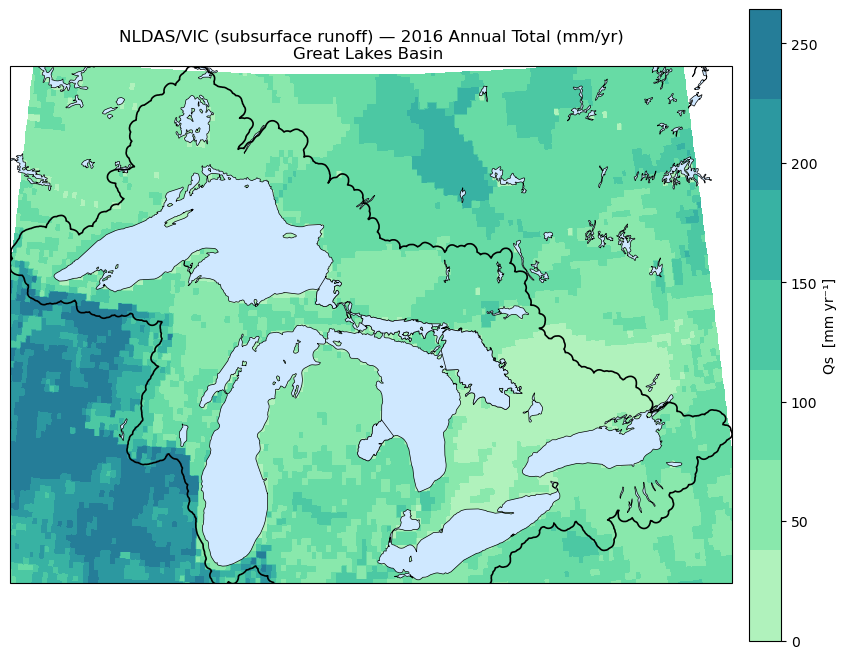

In [27]:
# ==== NLDAS/Mosaic Qs — 2016 Annual Total (mm/yr),
#      clipped to GL boundary, smooth plot in EPSG:3174
#      with lakes overlay ====
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps 
# -------------------- Paths & constants --------------------
ROOT_2016   = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\VIC\NLDAS\NLDAS_VIC0125_M.2.0\2016")
VAR         = "Qs"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT  = 4326
CRS_PLOT    = 3174  # Great Lakes Albers

# -------------------- Find which group contains the variable --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root
        return walk(nc, "")

# -------------------- Collect & open all 2016 files --------------------
files = sorted(str(p) for p in ROOT_2016.rglob("*.nc*"))
if not files:
    raise FileNotFoundError(f"No .nc/.nc4 files found under {ROOT_2016}")

group_path = find_group_with_var(files[0], VAR)
if group_path is None:
    raise KeyError(f"Variable '{VAR}' not found in {files[0]} (root or any subgroup).")
print(f"[INFO] '{VAR}' found in group: {group_path or '/'}")

open_kwargs = dict(
    combine="by_coords",
    chunks={"time": 12},
    parallel=False,
    decode_times=True,
    engine="netcdf4",
    backend_kwargs={"autoclose": True},
)
ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)
if VAR not in ds:
    raise KeyError(f"{VAR!r} not in dataset. Available: {list(ds.data_vars)[:20]}")

# -------------------- Annual total (mm/yr) --------------------
# Monthly totals: kg/m^2 == mm/month → sum across months
da = ds[VAR].sum("time", skipna=True)
da.attrs["units"] = "mm yr-1"
da.attrs["long_name"] = "Subsurface runoff (Qs) annual total"

# -------------------- Tidy coords (lon/lat ascending; lon in [-180,180]) --------------------
lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
if not (lon_name and lat_name):
    raise KeyError("Couldn't find lon/lat coords.")

lon_fix = xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])
da = da.assign_coords({lon_name: lon_fix})
if not np.all(np.diff(da[lon_name].values) > 0):
    da = da.sortby(lon_name)
if not np.all(np.diff(da[lat_name].values) > 0):
    da = da.sortby(lat_name)

lon_vals = da[lon_name].values
lat_vals = da[lat_name].values

# -------------------- Clip to GL boundary (mask on lon/lat grid) --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

masked = da
used_bbox_only = False
try:
    from rasterio.features import rasterize
    from affine import Affine
    dlon = float(lon_vals[1] - lon_vals[0])
    dlat = float(lat_vals[1] - lat_vals[0])
    transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                       float(lat_vals.min()) - dlat/2)
                    * Affine.scale(dlon, dlat))
    shapes = [(glb_poly.__geo_interface__, 1)]
    mask = rasterize(shapes, out_shape=(lat_vals.size, lon_vals.size),
                     transform=transform_ll, fill=0).astype(bool)
    masked = da.where(xr.DataArray(mask, dims=(lat_name, lon_name)), np.nan)
except Exception:
    used_bbox_only = True
    xmin, ymin, xmax, ymax = glb_ll.total_bounds
    masked = da.sel({lon_name: slice(xmin, xmax), lat_name: slice(ymin, ymax)})

# -------------------- Prep arrays for smooth plotting --------------------
da_plot = masked.transpose(lat_name, lon_name)  # (lat, lon)
Z = np.asarray(da_plot)

lat_for_extent = da_plot[lat_name].values
lon_for_extent = da_plot[lon_name].values

# Ensure imshow origin='lower' matches increasing lat/lon
if not np.all(np.diff(lat_for_extent) > 0):
    Z = Z[::-1, :]
    lat_for_extent = np.sort(lat_for_extent)
if not np.all(np.diff(lon_for_extent) > 0):
    Z = Z[:, ::-1]
    lon_for_extent = np.sort(lon_for_extent)

extent_lonlat = [float(lon_for_extent.min()), float(lon_for_extent.max()),
                 float(lat_for_extent.min()), float(lat_for_extent.max())]

# Robust color limits
finite = np.isfinite(Z)
vmin = np.nanpercentile(Z[finite], 2) if np.any(finite) else None
vmax = np.nanpercentile(Z[finite], 98) if np.any(finite) else None
if vmin is not None and vmax is not None and vmin >= vmax:
    vmin = vmax = None

# -------------------- Read + project lakes --------------------
lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

# -------------------- Plot (smooth, EPSG:3174) with GL extent + lakes --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=proj)

# Smooth raster (bilinear resampling lon/lat → EPSG:3174)
im = ax.imshow(
    Z,
    extent=extent_lonlat,
    transform=pc,             # data CRS
    origin="lower",
    interpolation="bilinear", # smoothing
    cmap=cmaps.tealgrn,
    vmin=vmin, vmax=vmax,
    zorder=1,
)

# Lakes (light blue fill, black edge)
lakes_proj.plot(
    ax=ax,
    facecolor="#cfe8ff",      # light blue fill
    edgecolor="black",        # black outline
    linewidth=0.5,
    zorder=2,
)

# GL boundary overlay
glb_proj = glb_ll.to_crs(CRS_PLOT)
glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

# Extent EXACTLY = GL_BOUNDARY extent in EPSG:3174
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps
ax.set_extent([minx, maxx, miny, maxy], crs=proj)

# Colorbar & title
cb = plt.colorbar(im, ax=ax, shrink=0.82, pad=0.02)
cb.set_label("Qs  [mm yr⁻¹]")

title = "NLDAS/VIC (subsurface runoff) — 2016 Annual Total (mm/yr)\nGreat Lakes Basin"
if used_bbox_only:
    title += " "
ax.set_title(title)
plt.savefig(Figures /"nldas_vic_qs_2016_glb.png", dpi=300)
plt.tight_layout()
plt.show()

# comparison 

[INFO] 'Qsb' found in group: / for MOSAIC
[INFO] 'Qsb' found in group: / for NOAH
[INFO] 'Qsb' found in group: / for VIC


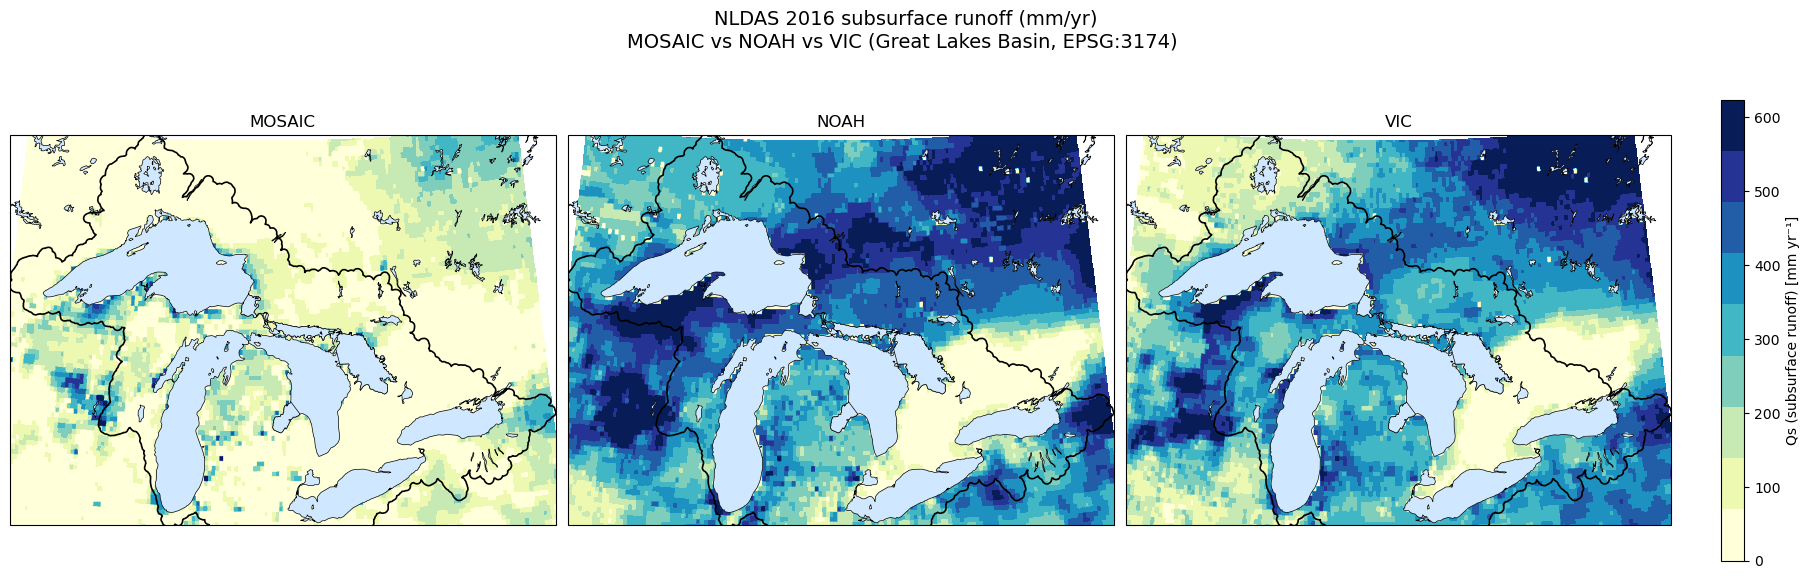

In [ ]:
# ==== NLDAS/Mosaic, NOAH, VIC Qs — 2016 Annual Total (mm/yr),
#      clipped to GL boundary, smooth tripanel comparison in EPSG:3174 ====

from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps 
# -------------------- Paths & constants --------------------
VAR = "Qsb"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)

MODEL_ROOTS = {
    "MOSAIC": Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016"),
    "NOAH":   Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Noah\NLDAS\NLDAS_NOAH0125_M.2.0\2016"),
    "VIC":    Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\VIC\NLDAS\NLDAS_VIC0125_M.2.0\2016"),
}

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT = 4326
CRS_PLOT   = 3174  # Great Lakes Albers

# -------------------- Helper: find group containing VAR --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root group
        return walk(nc, "")

# -------------------- Read GL boundary and lakes --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

glb_proj = glb_ll.to_crs(CRS_PLOT)
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps

# -------------------- Process models --------------------
masked_arrays = {}   # model_name -> 2D numpy array (lat x lon)
lon_vals = None
lat_vals = None
lon_name = None
lat_name = None
mask_arr = None
used_bbox_only = False

for model_name, root in MODEL_ROOTS.items():
    files = sorted(str(p) for p in root.rglob("*.nc*"))
    if not files:
        raise FileNotFoundError(f"No .nc/.nc4 files found under {root} for {model_name}")

    group_path = find_group_with_var(files[0], VAR)
    if group_path is None:
        raise KeyError(f"Variable '{VAR}' not found in {files[0]} for model {model_name}")
    print(f"[INFO] '{VAR}' found in group: {group_path or '/'} for {model_name}")

    open_kwargs = dict(
        combine="by_coords",
        chunks={"time": 12},
        parallel=False,
        decode_times=True,
        engine="netcdf4",
        backend_kwargs={"autoclose": True},
    )
    ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)
    if VAR not in ds:
        raise KeyError(f"{VAR!r} not in dataset for {model_name}. Available: {list(ds.data_vars)[:20]}")

    # Annual total (mm/yr) from monthly totals (kg/m^2 == mm)
    da = ds[VAR].sum("time", skipna=True)
    da.attrs["units"] = "mm yr-1"
    da.attrs["long_name"] = f"Qs annual total ({model_name})"

    # ---- Coordinate setup (do once, then align others) ----
    if lon_name is None or lat_name is None:
        lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
        lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
        if not (lon_name and lat_name):
            raise KeyError("Couldn't find lon/lat coords.")

        # normalize lon to [-180,180] and sort
        lon_fix = xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])
        da = da.assign_coords({lon_name: lon_fix})
        if not np.all(np.diff(da[lon_name].values) > 0):
            da = da.sortby(lon_name)
        if not np.all(np.diff(da[lat_name].values) > 0):
            da = da.sortby(lat_name)

        lon_vals = da[lon_name].values
        lat_vals = da[lat_name].values

        # Build mask once (GL boundary)
        try:
            from rasterio.features import rasterize
            from affine import Affine
            dlon = float(lon_vals[1] - lon_vals[0])
            dlat = float(lat_vals[1] - lat_vals[0])
            transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                               float(lat_vals.min()) - dlat/2)
                            * Affine.scale(dlon, dlat))
            shapes = [(glb_poly.__geo_interface__, 1)]
            mask_arr = rasterize(
                shapes,
                out_shape=(lat_vals.size, lon_vals.size),
                transform=transform_ll,
                fill=0
            ).astype(bool)
        except Exception:
            # bbox fallback: just crop to GL bounds in lon/lat
            used_bbox_only = True
            xmin_glb, ymin_glb, xmax_glb, ymax_glb = glb_ll.total_bounds
            da = da.sel({lon_name: slice(xmin_glb, xmax_glb),
                         lat_name: slice(ymin_glb, ymax_glb)})
            lon_vals = da[lon_name].values
            lat_vals = da[lat_name].values
            mask_arr = np.ones((lat_vals.size, lon_vals.size), dtype=bool)

    else:
        # align this model to the reference lon/lat grid
        # (NLDAS models should share grid, but interpolating is safe)
        da = da.assign_coords({lon_name: xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])})
        da = da.sortby(lon_name)
        da = da.sortby(lat_name)
        da = da.interp({lon_name: lon_vals, lat_name: lat_vals})

    # Apply mask
    da_masked = da.where(
        xr.DataArray(mask_arr, dims=(lat_name, lon_name)),
        np.nan
    )

    # Store as (lat, lon) numpy array
    da_plot = da_masked.transpose(lat_name, lon_name)
    Z = np.asarray(da_plot)
    masked_arrays[model_name] = Z

# -------------------- Common extent & color limits --------------------
# lon/lat extent from reference grid
extent_lonlat = [float(lon_vals.min()), float(lon_vals.max()),
                 float(lat_vals.min()), float(lat_vals.max())]

# stack all models to compute shared color limits
stacked = np.dstack(list(masked_arrays.values()))
finite_all = np.isfinite(stacked)
if np.any(finite_all):
    vmin = np.nanpercentile(stacked[finite_all], 2)
    vmax = np.nanpercentile(stacked[finite_all], 98)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
        vmin = vmax = None
else:
    vmin = vmax = None

# -------------------- Plot tripanel in EPSG:3174 --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    subplot_kw={"projection": proj},
    constrained_layout=True,
)

model_order = ["MOSAIC", "NOAH", "VIC"]
im = None

for ax, model_name in zip(axes, model_order):
    Z = masked_arrays[model_name]

    # Make sure orientation matches lon/lat increasing (already set by reference grid)
    # Smooth raster
    im = ax.imshow(
        Z,
        extent=extent_lonlat,
        transform=pc,
        origin="lower",
        interpolation="bilinear",
        cmap=cmaps.ylgnbu,
        vmin=vmin, vmax=vmax,
        zorder=1,
    )

    # Lakes (light blue fill, black edge)
    lakes_proj.plot(
        ax=ax,
        facecolor="#cfe8ff",
        edgecolor="black",
        linewidth=0.5,
        zorder=2,
    )

    # GL boundary outline
    glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

    # Extent EXACTLY = GL boundary bounds in EPSG:3174
    ax.set_extent([minx, maxx, miny, maxy], crs=proj)

    ax.set_title(f"{model_name}")

# Shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85, pad=0.03)
cbar.set_label("Qsb (subsurface runoff) [mm yr⁻¹]")

suptitle = "NLDAS 2016 subsurface runoff (mm/yr)\nMOSAIC vs NOAH vs VIC (Great Lakes Basin, EPSG:3174)"
if used_bbox_only:
    suptitle += " "
fig.suptitle(suptitle, fontsize=14)
plt.savefig(Figures / "nldas_qs_2016_glb_tripanel.png", dpi=300)
plt.show()


[INFO] 'Qs' found in group: / for MOSAIC
[INFO] 'Qs' found in group: / for NOAH
[INFO] 'Qs' found in group: / for VIC

===== Basin Aggregated Qs Comparison (mm/yr) — 2016, Great Lakes Basin =====

        area_mean  simple_mean  median  p10     p90
MOSAIC      31.90        32.42   16.64  0.0   95.28
NOAH        65.25        66.15   64.17  0.0  153.33
VIC         50.49        50.38   57.40  0.0   95.01


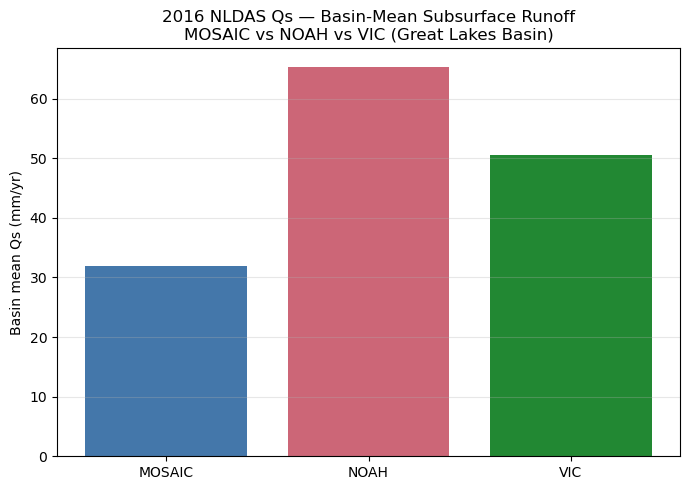

In [34]:
# ==== Basin Aggregated Comparison of Qs (mm/yr) — MOSAIC, NOAH, VIC (2016) ====

from pathlib import Path
import numpy as np
import xarray as xr
import geopandas as gpd
from netCDF4 import Dataset
from shapely.geometry import Point
from shapely.prepared import prep
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------
# 1. Paths & constants
# -------------------------------------------------------
ROOTS = {
    "MOSAIC": Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016"),
    "NOAH":   Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Noah\NLDAS\NLDAS_NOAH0125_M.2.0\2016"),
    "VIC":    Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\VIC\NLDAS\NLDAS_VIC0125_M.2.0\2016"),
}

VAR = "Qs"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)
GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"

# -------------------------------------------------------
# 2. Helper: find group containing VAR
# -------------------------------------------------------
def find_group(nc_path, var):
    def walk(g, path=""):
        if var in g.variables:
            return path
        for name, sub in g.groups.items():
            p = path + "/" + name if path else "/" + name
            out = walk(sub, p)
            if out:
                return out
        return None
    with Dataset(nc_path) as nc:
        if var in nc.variables:
            return ""
        return walk(nc)

# -------------------------------------------------------
# 3. Load GL boundary and build shapely mask (no rasterio)
# -------------------------------------------------------
glb = gpd.read_file(GL_BOUNDARY).to_crs(4326)
glb_poly = (glb.union_all() if hasattr(glb, "union_all") else glb.unary_union).buffer(0)
glb_prepared = prep(glb_poly)

# -------------------------------------------------------
# 4. Aggregation helper
# -------------------------------------------------------
def aggregate_stats(arr, weights):
    """
    arr: 2D array (lat x lon) in mm/yr, with NaNs outside grid/basin
    weights: 2D array same shape (area weights, e.g., cos(lat))
    """
    mask = np.isfinite(arr)
    if not np.any(mask):
        return {k: np.nan for k in ["area_mean", "simple_mean", "median", "p10", "p90"]}

    vals = arr[mask]
    w = weights[mask]

    stats = {
        "area_mean": np.average(vals, weights=w),
        "simple_mean": float(np.nanmean(vals)),
        "median": float(np.median(vals)),
        "p10": float(np.percentile(vals, 10)),
        "p90": float(np.percentile(vals, 90)),
    }
    return stats

# -------------------------------------------------------
# 5. Process each model
# -------------------------------------------------------
results = {}
lon_vals = None
lat_vals = None
basin_mask = None
weights_2d = None

for model, root in ROOTS.items():
    files = sorted(str(p) for p in root.rglob("*.nc*"))
    if not files:
        raise FileNotFoundError(f"No .nc/.nc4 files found under {root} for {model}")

    group_path = find_group(files[0], VAR)
    if group_path is None:
        raise KeyError(f"Variable '{VAR}' not found in {files[0]} for model {model}")
    print(f"[INFO] '{VAR}' found in group: {group_path or '/'} for {model}")

    ds = xr.open_mfdataset(
        files, group=(group_path or None),
        combine="by_coords", decode_times=True, parallel=False
    )
    if VAR not in ds:
        raise KeyError(f"{VAR!r} not in dataset for {model}. Available: {list(ds.data_vars)[:20]}")

    # Annual total (mm/yr) from monthly totals (kg/m^2 == mm/month)
    da = ds[VAR].sum("time", skipna=True)

    # Detect coord names
    lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
    lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
    if lon_name is None or lat_name is None:
        raise KeyError(f"Could not find lon/lat in coords for model {model}")

    # Normalize lon to [-180, 180], sort
    da = da.assign_coords({lon_name: xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])})
    da = da.sortby(lon_name).sortby(lat_name)

    if lon_vals is None:
        # First model → define common grid
        lon_vals = da[lon_name].values
        lat_vals = da[lat_name].values

        # Build 2D lon/lat grid
        LON2D, LAT2D = np.meshgrid(lon_vals, lat_vals)

        # Build basin mask via shapely (no rasterio)
        flat_mask = []
        for x, y in zip(LON2D.ravel(), LAT2D.ravel()):
            flat_mask.append(glb_prepared.contains(Point(float(x), float(y))))
        basin_mask = np.array(flat_mask, dtype=bool).reshape(LAT2D.shape)

        # Area weights ~ cos(lat)
        weights_2d = np.cos(np.deg2rad(lat_vals))[:, None] * np.ones_like(LON2D)

    else:
        # Align other models to the first model's grid
        da = da.interp({lon_name: lon_vals, lat_name: lat_vals})

    # Extract as numpy, apply mask
    arr = da.values  # 2D (lat, lon)
    arr_masked = np.where(basin_mask, arr, np.nan)

    # Aggregate
    stats = aggregate_stats(arr_masked, weights_2d)
    results[model] = stats

# -------------------------------------------------------
# 6. Put results in a DataFrame and plot
# -------------------------------------------------------
df = pd.DataFrame(results).T[
    ["area_mean", "simple_mean", "median", "p10", "p90"]
]
print("\n===== Basin Aggregated Qs Comparison (mm/yr) — 2016, Great Lakes Basin =====\n")
print(df.round(2))

# Bar plot of area-weighted mean
plt.figure(figsize=(7, 5))
plt.bar(df.index, df["area_mean"], color=["#4477aa", "#cc6677", "#228833"])
plt.ylabel("Basin mean Qs (mm/yr)")
plt.title("2016 NLDAS Qs — Basin-Mean Subsurface Runoff\nMOSAIC vs NOAH vs VIC (Great Lakes Basin)")
plt.grid(axis="y", alpha=0.3)
plt.savefig(Figures / "nldas_qs_2016_glb_basin_mean_comparison.png", dpi=300)
plt.tight_layout()
plt.show()


## comparison of recharge/rainfall ration 


[INFO] 'Qs' found in group: / for MOSAIC
[INFO] 'Qs' found in group: / for NOAH
[INFO] 'Qs' found in group: / for VIC


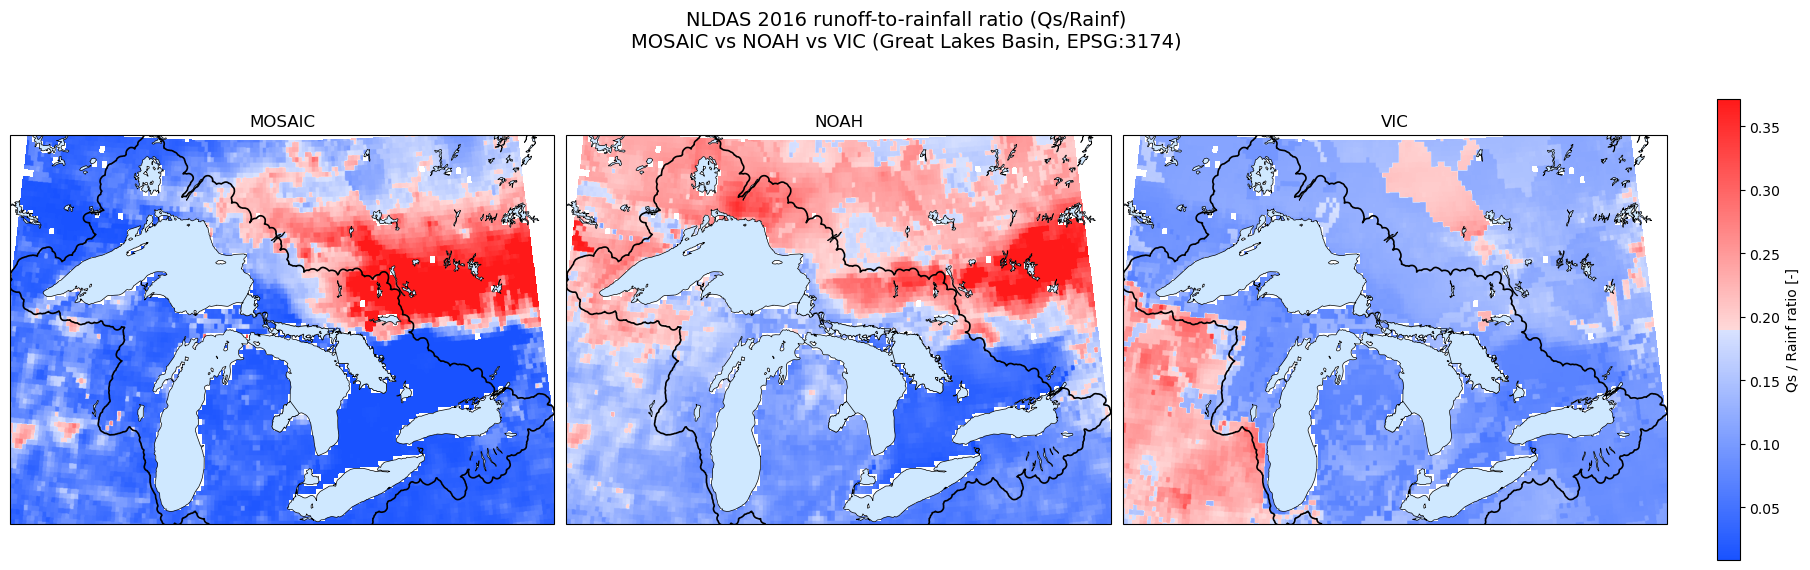

In [36]:
# ==== NLDAS/Mosaic, NOAH, VIC Qs/Rainf — 2016 Annual Ratio,
#      clipped to GL boundary, smooth tripanel comparison in EPSG:3174 ====

from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps  # your custom colormaps module

# -------------------- Paths & constants --------------------
VAR_QS   = "Qs"     # subsurface runoff, monthly totals (kg/m^2 == mm/month)
VAR_RAIN = "Rainf"  # rainfall, monthly totals (kg/m^2 == mm/month)

MODEL_ROOTS = {
    "MOSAIC": Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016"),
    "NOAH":   Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Noah\NLDAS\NLDAS_NOAH0125_M.2.0\2016"),
    "VIC":    Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\VIC\NLDAS\NLDAS_VIC0125_M.2.0\2016"),
}

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT = 4326
CRS_PLOT   = 3174  # Great Lakes Albers

# -------------------- Helper: find group containing a variable --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root group
        return walk(nc, "")

# -------------------- Read GL boundary and lakes --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

glb_proj = glb_ll.to_crs(CRS_PLOT)
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps

# -------------------- Process models --------------------
masked_arrays = {}   # model_name -> 2D numpy array (lat x lon) of Qs/Rainf
lon_vals = None
lat_vals = None
lon_name = None
lat_name = None
mask_arr = None
used_bbox_only = False

for model_name, root in MODEL_ROOTS.items():
    files = sorted(str(p) for p in root.rglob("*.nc*"))
    if not files:
        raise FileNotFoundError(f"No .nc/.nc4 files found under {root} for {model_name}")

    # Find group using Qs (Rainf should be in same group)
    group_path = find_group_with_var(files[0], VAR_QS)
    if group_path is None:
        raise KeyError(f"Variable '{VAR_QS}' not found in {files[0]} for model {model_name}")
    print(f"[INFO] '{VAR_QS}' found in group: {group_path or '/'} for {model_name}")

    open_kwargs = dict(
        combine="by_coords",
        chunks={"time": 12},
        parallel=False,
        decode_times=True,
        engine="netcdf4",
        backend_kwargs={"autoclose": True},
    )
    ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)

    if VAR_QS not in ds or VAR_RAIN not in ds:
        raise KeyError(
            f"Required variables not in dataset for {model_name}. "
            f"Have: {list(ds.data_vars)[:20]}"
        )

    # Annual totals (mm/yr) from monthly totals (kg/m^2 == mm/month)
    da_qs   = ds[VAR_QS].sum("time", skipna=True)
    da_rain = ds[VAR_RAIN].sum("time", skipna=True)

    # ---- Coordinate setup (do once, then align others) ----
    if lon_name is None or lat_name is None:
        lon_name = "lon" if "lon" in da_qs.coords else ("longitude" if "longitude" in da_qs.coords else None)
        lat_name = "lat" if "lat" in da_qs.coords else ("latitude" if "latitude" in da_qs.coords else None)
        if not (lon_name and lat_name):
            raise KeyError("Couldn't find lon/lat coords.")

        # normalize lon to [-180,180] and sort for BOTH Qs and Rainf
        lon_fix = xr.where(da_qs[lon_name] > 180, da_qs[lon_name] - 360, da_qs[lon_name])
        da_qs   = da_qs.assign_coords({lon_name: lon_fix})
        da_rain = da_rain.assign_coords({lon_name: lon_fix})

        if not np.all(np.diff(da_qs[lon_name].values) > 0):
            da_qs   = da_qs.sortby(lon_name)
            da_rain = da_rain.sortby(lon_name)
        if not np.all(np.diff(da_qs[lat_name].values) > 0):
            da_qs   = da_qs.sortby(lat_name)
            da_rain = da_rain.sortby(lat_name)

        lon_vals = da_qs[lon_name].values
        lat_vals = da_qs[lat_name].values

        # Build mask once (GL boundary)
        try:
            from rasterio.features import rasterize
            from affine import Affine
            dlon = float(lon_vals[1] - lon_vals[0])
            dlat = float(lat_vals[1] - lat_vals[0])
            transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                               float(lat_vals.min()) - dlat/2)
                            * Affine.scale(dlon, dlat))
            shapes = [(glb_poly.__geo_interface__, 1)]
            mask_arr = rasterize(
                shapes,
                out_shape=(lat_vals.size, lon_vals.size),
                transform=transform_ll,
                fill=0
            ).astype(bool)
        except Exception:
            # bbox fallback: just crop to GL bounds in lon/lat
            used_bbox_only = True
            xmin_glb, ymin_glb, xmax_glb, ymax_glb = glb_ll.total_bounds
            da_qs   = da_qs.sel({lon_name: slice(xmin_glb, xmax_glb),
                                 lat_name: slice(ymin_glb, ymax_glb)})
            da_rain = da_rain.sel({lon_name: slice(xmin_glb, xmax_glb),
                                   lat_name: slice(ymin_glb, ymax_glb)})
            lon_vals = da_qs[lon_name].values
            lat_vals = da_qs[lat_name].values
            mask_arr = np.ones((lat_vals.size, lon_vals.size), dtype=bool)

    else:
        # align this model to the reference lon/lat grid
        da_qs = da_qs.assign_coords({lon_name: xr.where(da_qs[lon_name] > 180, da_qs[lon_name] - 360, da_qs[lon_name])})
        da_rain = da_rain.assign_coords({lon_name: xr.where(da_rain[lon_name] > 180, da_rain[lon_name] - 360, da_rain[lon_name])})

        da_qs   = da_qs.sortby(lon_name).sortby(lat_name)
        da_rain = da_rain.sortby(lon_name).sortby(lat_name)

        da_qs   = da_qs.interp({lon_name: lon_vals, lat_name: lat_vals})
        da_rain = da_rain.interp({lon_name: lon_vals, lat_name: lat_vals})

    # Compute ratio Qs / Rainf, avoid divide-by-near-zero
    rain_thresh = 1e-3  # mm/yr threshold; adjust as needed
    valid = da_rain > rain_thresh
    da_ratio = xr.where(valid, da_qs / da_rain, np.nan)
    da_ratio.attrs["units"] = "-"
    da_ratio.attrs["long_name"] = f"Qs / Rainf ratio ({model_name})"

    # Apply GL mask
    da_masked = da_ratio.where(
        xr.DataArray(mask_arr, dims=(lat_name, lon_name)),
        np.nan
    )

    # Store as (lat, lon) numpy array
    da_plot = da_masked.transpose(lat_name, lon_name)
    Z = np.asarray(da_plot)
    masked_arrays[model_name] = Z

# -------------------- Common extent & color limits --------------------
# lon/lat extent from reference grid
extent_lonlat = [float(lon_vals.min()), float(lon_vals.max()),
                 float(lat_vals.min()), float(lat_vals.max())]

# stack all models to compute shared color limits for ratio
stacked = np.dstack(list(masked_arrays.values()))
finite_all = np.isfinite(stacked)
if np.any(finite_all):
    vmin = np.nanpercentile(stacked[finite_all], 2)
    vmax = np.nanpercentile(stacked[finite_all], 98)
    # If you want to cap the ratio, e.g., 0–1.5, uncomment:
    # vmin, vmax = 0.0, 1.5
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
        vmin = vmax = None
else:
    vmin = vmax = None

# -------------------- Plot tripanel in EPSG:3174 --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    subplot_kw={"projection": proj},
    constrained_layout=True,
)

model_order = ["MOSAIC", "NOAH", "VIC"]
im = None

for ax, model_name in zip(axes, model_order):
    Z = masked_arrays[model_name]

    im = ax.imshow(
        Z,
        extent=extent_lonlat,
        transform=pc,
        origin="lower",
        interpolation="bilinear",
        cmap=cmaps.BlueRed,  # your YlGnBu colormap
        vmin=vmin, vmax=vmax,
        zorder=1,
    )

    # Lakes (light blue fill, black edge)
    lakes_proj.plot(
        ax=ax,
        facecolor="#cfe8ff",
        edgecolor="black",
        linewidth=0.5,
        zorder=2,
    )

    # GL boundary outline
    glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

    # Extent EXACTLY = GL boundary bounds in EPSG:3174
    ax.set_extent([minx, maxx, miny, maxy], crs=proj)

    ax.set_title(f"{model_name}")

# Shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85, pad=0.03)
cbar.set_label("Qs / Rainf ratio [-]")

suptitle = "NLDAS 2016 runoff-to-rainfall ratio (Qs/Rainf)\nMOSAIC vs NOAH vs VIC (Great Lakes Basin, EPSG:3174)"
if used_bbox_only:
    suptitle += ""
fig.suptitle(suptitle, fontsize=14)

# If you want to save:
# Figures = Path(r"your\figure\folder")
plt.savefig(Figures / "nldas_qs_rainf_ratio_2016_glb_tripanel.png", dpi=300)

plt.show()


# Read NLDAS-3 forcing data

In [15]:

from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
fn = r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS-3\NLDAS_FOR0010_H.A20150101.030.beta.nc"

ds_raw = xr.open_dataset(fn, decode_cf=False)
ds_raw

<xarray.Dataset> Size: 58GB
Dimensions:  (lon: 11700, lat: 6500, time: 24)
Coordinates:
  * lon      (lon) float32 47kB -169.0 -169.0 -169.0 ... -52.03 -52.01 -52.0
  * lat      (lat) float32 26kB 7.005 7.015 7.025 7.035 ... 71.97 71.98 71.99
  * time     (time) float64 192B 1.227e+05 1.227e+05 ... 1.227e+05 1.227e+05
Data variables:
    Tair     (time, lat, lon) float32 7GB ...
    Qair     (time, lat, lon) float32 7GB ...
    PSurf    (time, lat, lon) float32 7GB ...
    LWdown   (time, lat, lon) float32 7GB ...
    SWdown   (time, lat, lon) float32 7GB ...
    Wind_N   (time, lat, lon) float32 7GB ...
    Wind_E   (time, lat, lon) float32 7GB ...
    Rainf    (time, lat, lon) float32 7GB ...
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FOR0010_H_3.0
    title:                  NLDAS Forcing Data L4 Hourly 0.01 x 0.01 degree V...
    version:                3.0 beta
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/v3/ ; https://li...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  7.005
    SOUTH_WEST_CORNER_LON:  -168.995
    DX:                     0.01
    DY:                     0.01

In [11]:
DATASET_PATH = r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS-3\NLDAS_FOR0010_H.A20150101.030.beta.nc"


In [14]:
# === Imports ===
import xarray as xr
import geopandas as gpd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.path import Path as MplPath

# =========================================================
# CONFIG (edit as needed)
# =========================================================
DATASET_PATH = None   # e.g., r"D:\path\to\NLDAS_or_NCALDAS.nc"; keep None if ds_raw already open
VAR_NAME     = "Rainf"
GL_BOUNDARY  = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
CMAP         = "cividis"   # e.g., "magma", "viridis", "turbo", "Blues"
TIME_STRIDE  = 1           # 1 = every timestep; 6 = every 6th
OUT_DIR      = Path("rainf_glb_mmph_frames")
DPI          = 150

# =========================================================
# 0) Open dataset if not already loaded in your session
# =========================================================
try:
    ds_raw  # already defined?
except NameError:
    if not DATASET_PATH:
        raise RuntimeError("Set DATASET_PATH to your NetCDF file or define ds_raw before running.")
    ds_raw = xr.open_dataset(DATASET_PATH)

assert VAR_NAME in ds_raw, f"Variable '{VAR_NAME}' not found."
assert "time" in ds_raw.coords, "Expected a 'time' coordinate."

# =========================================================
# 1) Read GL boundary & reproject to WGS84, dissolve to single MultiPolygon
# =========================================================
def to_wgs84(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf.crs is None:
        gdf = gdf.set_crs(4326, allow_override=True)
    else:
        gdf = gdf.to_crs(4326)
    return gdf

glb = to_wgs84(gpd.read_file(GL_BOUNDARY))
# Deprecation-safe dissolve to one geometry
try:
    glb_geom = glb.union_all().buffer(0)
except AttributeError:
    glb_geom = glb.unary_union.buffer(0)

# =========================================================
# 2) Handle lon/lat names & subset to boundary bbox (speed)
# =========================================================
def get_lon_lat(ds):
    if "lon" in ds.coords and "lat" in ds.coords:
        return ds["lon"], ds["lat"]
    if "longitude" in ds.coords and "latitude" in ds.coords:
        return ds["longitude"], ds["latitude"]
    raise KeyError("Could not find lon/lat (or longitude/latitude) coordinates.")

lon, lat = get_lon_lat(ds_raw)
xmin, ymin, xmax, ymax = glb.total_bounds

# Make slices respect coord order
lat_asc = lat.values[0] < lat.values[-1]
lon_asc = lon.values[0] < lon.values[-1]
lat_slice = slice(ymin, ymax) if lat_asc else slice(ymax, ymin)
lon_slice = slice(xmin, xmax) if lon_asc else slice(xmax, xmin)

ds_sub  = ds_raw.sel(lat=lat_slice, lon=lon_slice)
lon_sub = (ds_sub["lon"] if "lon" in ds_sub.coords else ds_sub["longitude"]).values
lat_sub = (ds_sub["lat"] if "lat" in ds_sub.coords else ds_sub["latitude"]).values

# Render in ascending order for imshow(origin='lower')
lon_sorted = np.sort(lon_sub)
lat_sorted = np.sort(lat_sub)

# =========================================================
# 3) Build basin mask WITHOUT shapely.vectorized/rasterio using Matplotlib Path
#    True inside basin, False outside; supports holes.
# =========================================================
def multipolygon_mask(geom, lon_vec, lat_vec):
    """Return a boolean mask [lat,lon] True inside the (Multi)Polygon (handles holes)."""
    if geom.is_empty:
        return np.zeros((lat_vec.size, lon_vec.size), dtype=bool)

    X, Y = np.meshgrid(lon_vec, lat_vec)               # (H,W)
    pts = np.column_stack([X.ravel(), Y.ravel()])      # (H*W, 2)

    def polygon_mask(poly):
        ext_xy = np.asarray(poly.exterior.coords)
        ext_path = MplPath(ext_xy, closed=True)
        inside = ext_path.contains_points(pts)
        if poly.interiors:
            for ring in poly.interiors:
                in_xy = np.asarray(ring.coords)
                in_path = MplPath(in_xy, closed=True)
                inside &= ~in_path.contains_points(pts)
        return inside

    inside_flat = np.zeros(pts.shape[0], dtype=bool)
    if geom.geom_type == "Polygon":
        inside_flat |= polygon_mask(geom)
    else:
        for poly in geom.geoms:  # MultiPolygon
            inside_flat |= polygon_mask(poly)

    return inside_flat.reshape(lat_vec.size, lon_vec.size)

mask_inside = multipolygon_mask(glb_geom, lon_sorted, lat_sorted)

# =========================================================
# 4) Convert Rainf → mm/h
# =========================================================
def to_mm_per_hour(da: xr.DataArray) -> xr.DataArray:
    """
    Convert Rainf DataArray to mm/h.
    - If units are kg m-2 s-1 (or similar): multiply by 3600 (since 1 kg m-2 == 1 mm).
    - If units are kg m-2 (per-timestep totals): divide by Δt_hours inferred from the time axis.
    """
    units = (da.attrs.get("units", "") or "").lower().replace("**", "").replace("^", "")
    # normalize some common spellings
    units = units.replace("kg/m2", "kg m-2").replace("kg m-2 s-1", "kg m-2 s-1").strip()

    if "s-1" in units or "/s" in units:
        mmph = da * 3600.0
    else:
        # treat as per-timestep total (kg m-2 == mm); need Δt in hours
        t = da["time"]
        # try to compute time step in hours robustly
        try:
            # Works if time is datetime64
            dt_hours = (t.diff("time").astype("timedelta64[s]").astype(np.int64) / 3600.0).median().item()
        except Exception:
            # cftime or odd calendars: fall back to xarray's to_datetimeindex if possible
            try:
                dt_hours = (t.to_pandas().diff().dt.total_seconds().median()) / 3600.0
            except Exception:
                dt_hours = 1.0  # safe fallback; adjust if you know your Δt
        if not np.isfinite(dt_hours) or dt_hours <= 0:
            dt_hours = 1.0
        mmph = da / dt_hours

    mmph = mmph.copy()
    mmph.attrs.update(da.attrs)
    mmph.attrs["units"] = "mm h-1"
    longn = da.attrs.get("long_name", VAR_NAME)
    mmph.attrs["long_name"] = f"{longn} (mm/h)"
    return mmph

rain_raw = ds_sub[VAR_NAME]
rain_mmph = to_mm_per_hour(rain_raw)

# =========================================================
# 5) Color limits (robust) & extent
# =========================================================
nT = ds_sub.sizes["time"]
sample_idx = np.linspace(0, max(0, nT-1), num=min(24, nT), dtype=int)

acc = []
for ti in sample_idx:
    Z = rain_mmph.isel(time=ti).values
    if not lat_asc: Z = Z[::-1, :]
    if not lon_asc: Z = Z[:, ::-1]
    acc.append(np.where(mask_inside, Z, np.nan))

if acc:
    stacked = np.dstack(acc)
    vmin = np.nanpercentile(stacked, 2)
    vmax = np.nanpercentile(stacked, 98)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
        vmin, vmax = None, None
else:
    vmin = vmax = None

imshow_extent = [lon_sorted.min(), lon_sorted.max(), lat_sorted.min(), lat_sorted.max()]

def fmt_time(tval):
    try:
        return np.datetime_as_string(np.array(tval).astype("datetime64[h]"))
    except Exception:
        return str(tval)

# =========================================================
# 6) Render frames (fast: imshow + PlateCarree)
# =========================================================
OUT_DIR.mkdir(parents=True, exist_ok=True)
pc = ccrs.PlateCarree()
proj = ccrs.PlateCarree()  # stay in data CRS

indices = range(0, nT, TIME_STRIDE)
skipped = []

for idx, ti in enumerate(indices):
    try:
        da = rain_mmph.isel(time=ti)
        Z  = da.values
        if not lat_asc: Z = Z[::-1, :]
        if not lon_asc: Z = Z[:, ::-1]
        Z  = np.where(mask_inside, Z, np.nan)

        fig = plt.figure(figsize=(7.6, 6.6))
        ax = plt.axes(projection=proj)
        ax.set_extent([xmin, xmax, ymin, ymax], crs=pc)

        im = ax.imshow(
            Z,
            extent=imshow_extent,
            origin="lower",
            transform=pc,
            interpolation="nearest",
            zorder=1,
            cmap=CMAP,
            vmin=vmin, vmax=vmax
        )

        # GL boundary with black outline
        glb.plot(ax=ax, transform=pc, facecolor="none", edgecolor="black", linewidth=1.2, zorder=3)

        cb = plt.colorbar(im, ax=ax, shrink=0.86, pad=0.02)
        cb.set_label(f"{da.attrs.get('long_name', VAR_NAME)} [{da.attrs.get('units','mm h-1')}]")
        ax.set_title(f"{da.attrs.get('long_name', VAR_NAME)} — {fmt_time(ds_sub['time'].isel(time=ti).values)}")

        out_png = OUT_DIR / f"{VAR_NAME}_mmph_glb_{idx:05d}_t{ti:05d}.png"
        plt.savefig(out_png, dpi=DPI, bbox_inches="tight")
        plt.close(fig)

    except Exception as e:
        print(f"[skip] t={ti}: {e}")
        skipped.append(ti)

print(f"Frames written: {len(list(indices)) - len(skipped)} → {OUT_DIR.resolve()}")
if skipped:
    print("Skipped timesteps:", skipped)


C:\Users\abolmaal\AppData\Local\Temp\ipykernel_35488\1517384845.py:133: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dt_hours = (t.diff("time").astype("timedelta64[s]").astype(np.int64) / 3600.0).median().item()


Frames written: 24 → \\wsl.localhost\Samin_Ubuntu\home\abolmaal\Code\Projects\groundwater\rainf_glb_mmph_frames


In [18]:
from pathlib import Path
import xarray as xr
import numpy as np

ROOT = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS-3")
PATTERNs = ("*.nc", "*.nc4", "*.nc3")  # extend if needed

def find_time_coord(ds):
    # 1) obvious names
    for name in ("time","Time","t","TIME"):
        if name in ds.coords:
            return name
    # 2) any coord with datetime-like dtype
    for name, coord in ds.coords.items():
        try:
            if np.issubdtype(coord.values.dtype, np.datetime64):
                return name
        except Exception:
            pass
    # 3) last resort: any 1D coord named like time
    for name in ds.coords:
        if "time" in name.lower():
            return name
    raise KeyError("No time coordinate found")

def get_time_range_one_file(fp):
    """Return (tmin, tmax) as strings, or raise with context."""
    last_err = None
    for eng in (None, "h5netcdf", "netcdf4"):
        try:
            # open without loading data; let xarray decode times
            with xr.open_dataset(fp, engine=eng, chunks={}, decode_times=True) as ds:
                tname = find_time_coord(ds)
                tvals = ds[tname].values
                # Handle cftime: just convert to strings
                if hasattr(tvals, "dtype") and np.issubdtype(getattr(tvals, "dtype", object), np.datetime64):
                    tmin = np.datetime_as_string(tvals.min().astype("datetime64[s]"))
                    tmax = np.datetime_as_string(tvals.max().astype("datetime64[s]"))
                else:
                    # cftime or object; stringify robustly
                    tmin = str(tvals[0])
                    tmax = str(tvals[-1])
                return tname, tmin, tmax
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to read time from {fp} (last error: {last_err})")

# Gather files
files = []
for pat in PATTERNs:
    files.extend(ROOT.rglob(pat))  # use .glob if you don't want subfolders
files = sorted(files)
if not files:
    print("No NetCDF files found.")
else:
    overall_min = None
    overall_max = None
    rows = []
    for i, fp in enumerate(files, 1):
        try:
            tname, tmin, tmax = get_time_range_one_file(fp)
            rows.append((fp.name, tname, tmin, tmax))
            # Try to keep overall min/max as strings but also parse if possible
            def to_npdt(s):
                try:
                    return np.datetime64(s)
                except Exception:
                    return None
            dt_min = to_npdt(tmin)
            dt_max = to_npdt(tmax)
            if dt_min is not None:
                overall_min = dt_min if overall_min is None else min(overall_min, dt_min)
            if dt_max is not None:
                overall_max = dt_max if overall_max is None else max(overall_max, dt_max)
        except Exception as e:
            rows.append((fp.name, "—", f"ERROR: {e}", "—"))

    # Print table
    w0 = max(12, *(len(r[0]) for r in rows))
    print(f"{'FILE':{w0}}  {'time_coord':10}  {'start':25}  {'end':25}")
    print("-"*(w0+65))
    for fname, tname, tmin, tmax in rows:
        print(f"{fname:{w0}}  {tname:10}  {tmin:25}  {tmax:25}")

    # Overall range
    if overall_min is not None and overall_max is not None:
        print("\nOVERALL RANGE:")
        print("  start:", np.datetime_as_string(overall_min.astype("datetime64[s]")))
        print("  end  :", np.datetime_as_string(overall_max.astype("datetime64[s]")))
    else:
        print("\nOVERALL RANGE: (mixed/non-ISO calendars; see per-file rows above)")


FILE                                   time_coord  start                      end                      
------------------------------------------------------------------------------------------------------
NLDAS_FOR0010_H.A20150101.030.beta.nc  time        2015-01-01T00:00:00        2015-01-01T23:00:00      
NLDAS_FOR0010_H.A20150102.030.beta.nc  time        2015-01-02T00:00:00        2015-01-02T23:00:00      
NLDAS_FOR0010_H.A20150103.030.beta.nc  time        2015-01-03T00:00:00        2015-01-03T23:00:00      
NLDAS_FOR0010_H.A20150104.030.beta.nc  time        2015-01-04T00:00:00        2015-01-04T23:00:00      
NLDAS_FOR0010_H.A20150105.030.beta.nc  time        2015-01-05T00:00:00        2015-01-05T23:00:00      
NLDAS_FOR0010_H.A20150106.030.beta.nc  time        2015-01-06T00:00:00        2015-01-06T23:00:00      
NLDAS_FOR0010_H.A20150107.030.beta.nc  time        2015-01-07T00:00:00        2015-01-07T23:00:00      
NLDAS_FOR0010_H.A20150108.030.beta.nc  time        2015-01-08T00: